# 7. Visualizing Linear Model Results

## 7.1 Imports

In [1]:
library(tidyverse)
library(ggimage)
library(here)

source(here("R", "00_source.R"))

specialistData <- read.csv(here("data", "specialist_data.csv"), 
                           na.strings = c('NA', NA, '', ' '))

returns <- specialistData[which(specialistData$specialTeamsResult == 'Return'), ]

# recreate model
fSelectedAIC <- lm(formula = returnYds ~ timeToBeatVise + disFromReturner + speedDev + 
                   squeezeDis + disFromLOS + missedTackle, data = na.omit(returns))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

here() starts at C:/Users/Hunter



## 7.2 Record Model Results

### 7.2.1 Create Dataframe to Store Gunner Data

In [2]:
gunners <- unique(specialistData$gunnerId)

gunnerRanked <- data.frame(gunnerId = gunners,
                           gunnerName = character(length(gunners)),
                           gunnerTeam = character(length(gunners)),
                           timeToBeatVise = numeric(length(gunners)),
                           squeezeDis = numeric(length(gunners)),
                           disFromReturner = numeric(length(gunners)),
                           disFromLOS = numeric(length(gunners)),
                           missedTackle = numeric(length(gunners)),
                           speedDev = numeric(length(gunners)),
                           exReturnYds = numeric(length(gunners)),
                           returnYds = numeric(length(gunners)),
                           playCount = numeric(length(gunners)))

### 7.2.2 Record Gunner Averages

In [3]:
for (i in 1:nrow(gunnerRanked)) {
  gunnerId <- gunnerRanked$gunnerId[i]
  gunnerRanked$gunnerName[i] <- specialistData$gunnerName[specialistData$gunnerId == gunnerId][1]
  gunnerRanked$gunnerTeam[i] <- specialistData$gunnerTeam[specialistData$gunnerId == gunnerId][1]
  gunnerRanked$timeToBeatVise[i] <- mean(specialistData$timeToBeatVise[specialistData$gunnerId == gunnerId], 
                                         na.rm = T)
  gunnerRanked$squeezeDis[i] <- mean(specialistData$squeezeDis[specialistData$gunnerId == gunnerId &
                                                               specialistData$specialTeamsResult == 'Return'], 
                                     na.rm = T)
  gunnerRanked$disFromReturner[i] <- mean(specialistData$disFromReturner[specialistData$gunnerId == gunnerId], 
                                          na.rm = T)
  gunnerRanked$disFromLOS[i] <- mean(specialistData$disFromLOS[specialistData$gunnerId == gunnerId], 
                                     na.rm = T)
  gunnerRanked$missedTackle[i] <- mean(specialistData$missedTackle[specialistData$gunnerId == gunnerId], 
                                       na.rm = T)
  gunnerRanked$speedDev[i] <- mean(specialistData$speedDev[specialistData$gunnerId == gunnerId], 
                                   na.rm = T)
  gunnerRanked$returnYds[i] <- mean(specialistData$returnYds[specialistData$gunnerId == gunnerId], 
                                    na.rm = T)
}

### 7.2.3 Predict Expected Yards Given Up Based on Averages

In [4]:
gunnerRanked$exReturnYds <- predict(fSelectedAIC, gunnerRanked[, c(4,6,9,5,7,8)])

### 7.2.4 Filter to Gunners Who Played in at Least 30 Plays

In [5]:
gunnerRanked$playCount <- vapply(gunnerRanked$gunnerId, 
                                 function(x) length(which(specialistData$gunnerId == x)), 
                                 numeric(1))

gunnerRankedQual <- gunnerRanked %>% filter(playCount >= 30)

## 7.3 Visualization
Here are the top 10 gunners in the NFL from 2018-2020 ranked by expected return yards.

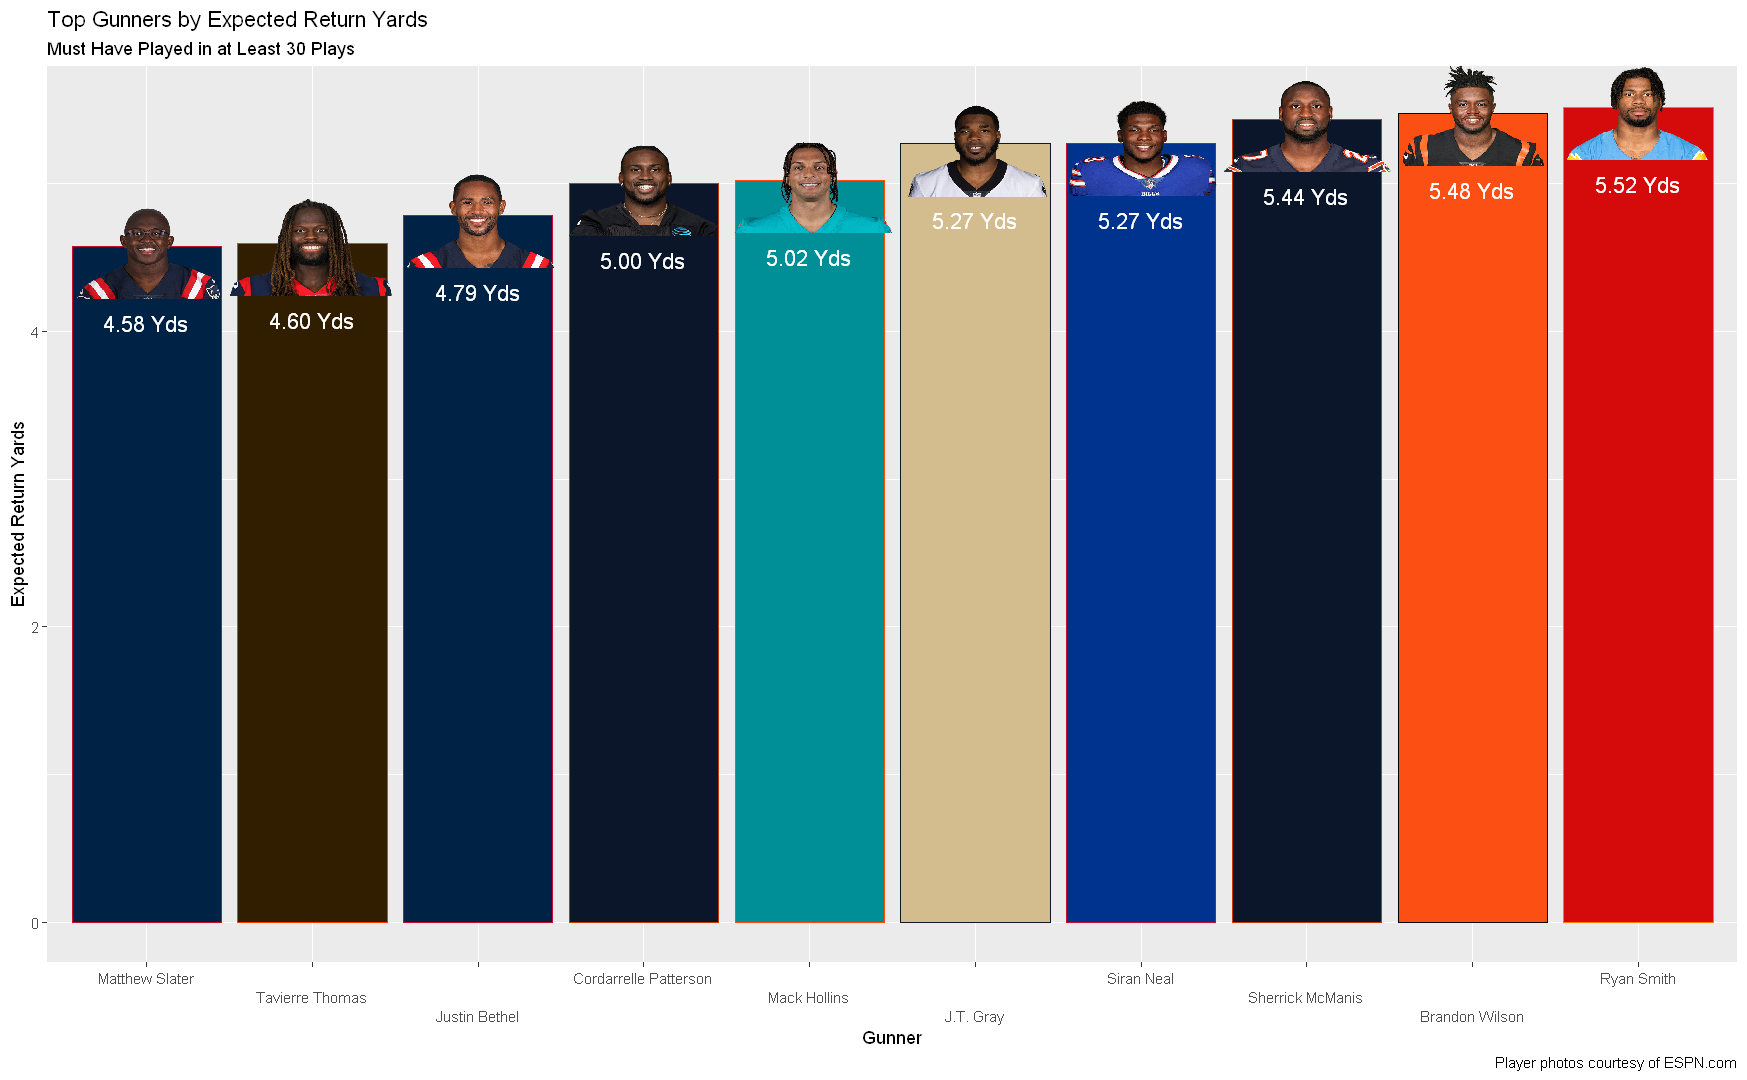

In [6]:
# adjust plot size
options(repr.plot.width=14.5623, repr.plot.height=9)

# get path to images
images <- c('m_slater.png', 't_thomas.png', 'j_bethel.png', 'c_patterson.png', 'm_hollins.png', 'j_gray.png', 
            's_neal.png', 's_mcmanis.png', 'b_wilson.png', 'r_smith.png')

images <- here("images", images)

# scale images
asp_ratio <- 1.618

# get top 10 gunners by expected return yards
top10exYds <- gunnerRankedQual[order(gunnerRankedQual$exReturnYds), ][c(1:10),]
top10exYds$image <- images

# plot
ggplot() +
  geom_bar(data = top10exYds, aes(x=reorder(gunnerName, exReturnYds), y=exReturnYds, fill=gunnerName, 
                                  color = gunnerName), stat='identity') +
  geom_image(data = top10exYds, aes(x=gunnerName, y=exReturnYds, image = images ), 
             size = 0.1, by = 'width', asp = asp_ratio) +
  geom_text(data = top10exYds, aes(x = gunnerName, y = exReturnYds, 
                                   label = paste(format(round(exReturnYds, 2), nsmall = 2), 'Yds'), 
                                   vjust=5, color = 'white', size = 3.5)) +
  labs(title='Top Gunners by Expected Return Yards', 
       subtitle = 'Must Have Played in at Least 30 Plays', 
       caption = 'Player photos courtesy of ESPN.com') +
  scale_x_discrete(guide = guide_axis(n.dodge=3)) +
  xlab('Gunner')+
  ylab('Expected Return Yards') +
  theme(legend.position = "none") +
  scale_fill_manual(values = c('#fb4f14', '#0B162A', '#D3BC8D', '#002244', '#008E97', 
                               '#002244', '#D50A0A', '#0B162A', '#00338D', '#311D00')) +
  scale_color_manual(values = c('#000000', '#c83803', '#101820', '#C60C30', '#FC4C02', 
                                '#C60C30', '#FF7900', '#c83803', '#C60C30', '#ff3c00', '#FFFFFF'))

## 7.4 Write to .csv

In [7]:
write.csv(gunnerRankedQual, file = here("data", 'gunner_stats_exYds.csv'), row.names = FALSE)

## 7.5 Save Plot

In [8]:
ggsave("expected_yards.png", path = here("output"), width = 9.7082, height = 6)